# Le Grand Mix
Ensemble averaging is responsible for 5% in test accuracy improvements:

1. the Simple 5-Layer CNN (Model 1)
2. Wider Simple 5-Layer CNN (Model 2)
3. 6-layer All-CNN (Model3-5)
4. 7-layer All-CNN (Model3-8)

We want to conduct an experiment to see how the improvements from ensemble averaging is dependent on:

* Model criteria (top validation accuracy)
* Number of models to ensemble


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import os
import numpy as np
import timeit
import time
import platform
import random
import pickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version:  3.6.4


In [2]:
import torchvision.transforms as transforms

class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 48000
NUM_VAL = 2000
NUM_TRAIN_SMALL=1000

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([
    # transforms.RandomResizedCrop(32),  # data augmentation - random crop
    transforms.RandomHorizontalFlip(),      # data augmentation - horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))
loader_train_small = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True, 
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                          transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [85]:
cpu_dtype = torch.FloatTensor # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def check_accuracy(model, loader, verbose=False, dtype=gpu_dtype):
    if verbose:
        if loader.dataset.train:
            print('Checking accuracy on validation set')
        else:
            print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def create_ensemble(files, num_models):
    """
    This function generate an ensemble of a specified size randomly from files.
    """
    
    # Randomly generate ensemble
    ensemble = []
    selection = np.random.choice(len(files), num_models,replace=False)
    for n in selection:
        ensemble.append(files[n])
    return ensemble  

def load_ensemble_models(ensemble, generator):
    """
    This function load an ensemble of models with files provided
    """
    
    for n in range(len(ensemble)):
        model = generator().type(gpu_dtype)
   
        # Load trained parameters into model
        file_name = ensemble[n]
        model.load_state_dict(torch.load(file_name))
        model.eval() # Put the model in test mode (the opposite of model.train(), essentially)    

        models.append(model)  # Create a list of models 
    return models

def calc_ensemble_accuracy(models):
    """
    This function load an ensemble of models with files provided
    """
    num_correct = 0
    num_samples = 0
    i = 0

    for x, y in loader_test:
        x_var = Variable(x.type(gpu_dtype), volatile=True)
        num_samples += x.size()[0]
        scores_sum = torch.zeros(x.size()[0],10).type(gpu_dtype)
    
        for n in range(len(models)):
            scores = models[n](x_var)
            scores_sum += scores.data

        y_pred = scores_sum.cpu().max(1)[1]
        num_correct += (y_pred == y).sum()

    return float(num_correct) / num_samples  # ensemble test accuracy


In [5]:
def generator_m1():

    # Model1 - 5 layer Conv Layers (WIDE)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(16384,1024),  # 5408=128*16*16 input size
                    nn.BatchNorm1d(1024),
                    nn.ReLU(inplace=True),
                    nn.Linear(1024,10),
                    )
    
    
    return model


def generator_m2():

    # Model2 - Original Simple 5 layer Conv Layers

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(8192,512),  # 5408=128*16*16 input size
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Linear(512,10),
                    )
    
    
    return model  


def generator_m35():

    # Model3-5 - Wide 6 layer Conv Layers - replace 1st maxpools with conv(stride=2)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half      
                    Flatten(),
                    nn.Linear(16384,512),  # 16384=256*8*8 input size
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Linear(512,10)
                    )
    return model

   

def generator_m38():

    # Model3-8 - Wide 7 layer Conv Layers - replace both maxpools with conv(stride=2)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=2,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    Flatten(),
                    nn.Linear(16384,512),  # 16384=256*8*8 input size
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Linear(512,10)
                    )
    return model


### Dimension Check

Handy to check dimension when putting together a CNN architecture

In [6]:
generators = [generator_m1, generator_m2, generator_m35, generator_m38]

for generator in generators:
    model = generator().type(gpu_dtype)
    print (model)
    
    x_gpu = torch.randn(64, 3, 32, 32).type(gpu_dtype)
    x_var_gpu = Variable(x_gpu.type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
    ans = model(x_var_gpu)        # Feed it through the model! 

    print (ans.shape)

    # Check to make sure what comes out of your model
    # is the right dimensionality... this should be True
    # if you've done everything correctly
    print (np.array_equal(np.array(ans.size()), np.array([64, 10])))

Sequential(
  (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (3): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (6): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (13): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace)
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Flatten(
  )
  (18): Linear(in_features=16384

## Simple 5-Layer CNN

There are model parameters from 100 permutations for Simple 5-Layer CNN. We will first look at the distribution of validation and test accuracies.


In [63]:
m2_dir = "./m2-50ep-results/"

accuracies =[]
files = os.listdir(m2_dir)

for file_name in files:
    best_model = generator_m2().type(gpu_dtype)
    file_path = m2_dir+file_name
    best_model.load_state_dict(torch.load(file_path))
    
    test_acc = check_accuracy(best_model, loader_test, dtype=gpu_dtype)
    val_acc = check_accuracy(best_model, loader_val, dtype=gpu_dtype)

    print ("test acc={:.4f}  val acc={:.4f} ".format(test_acc, val_acc))
    accuracies.append([test_acc, val_acc, file_path])



test acc=0.8225  val acc=0.8830 
test acc=0.8273  val acc=0.8965 
test acc=0.8216  val acc=0.8835 
test acc=0.8162  val acc=0.8745 
test acc=0.8100  val acc=0.8830 
test acc=0.8277  val acc=0.8955 
test acc=0.8216  val acc=0.8830 
test acc=0.8225  val acc=0.8880 
test acc=0.8233  val acc=0.8930 
test acc=0.8107  val acc=0.8815 
test acc=0.8259  val acc=0.8800 
test acc=0.8177  val acc=0.8855 
test acc=0.8337  val acc=0.8930 
test acc=0.8165  val acc=0.8750 
test acc=0.8052  val acc=0.8820 
test acc=0.8174  val acc=0.8845 
test acc=0.8223  val acc=0.8790 
test acc=0.8262  val acc=0.8900 
test acc=0.8222  val acc=0.8695 
test acc=0.8274  val acc=0.8910 
test acc=0.8200  val acc=0.8770 
test acc=0.8202  val acc=0.8830 
test acc=0.8296  val acc=0.8945 
test acc=0.8361  val acc=0.8900 
test acc=0.8325  val acc=0.9015 
test acc=0.8122  val acc=0.8745 
test acc=0.8131  val acc=0.8865 
test acc=0.8231  val acc=0.8900 
test acc=0.8223  val acc=0.8900 
test acc=0.8282  val acc=0.8940 
test acc=0

In [64]:
sorted_list = sorted(accuracies, key=lambda x: x[1], reverse=True)   # sort file list by validation accuracy

for record in sorted_list:
    print ("test acc={:.4f}  val acc={:.4f}  Model:{}".format(record[0],record[1],record[2]))


test acc=0.8325  val acc=0.9015  Model:./m2-50ep-results/model2_reg=6.8983e-07lr=1.2029e-03ep=50bestacc.pt
test acc=0.8305  val acc=0.8975  Model:./m2-50ep-results/model2_reg=6.1658e-08lr=2.0773e-03ep=50bestacc.pt
test acc=0.8273  val acc=0.8965  Model:./m2-50ep-results/model2_reg=2.3648e-07lr=1.9457e-03ep=50bestacc.pt
test acc=0.8277  val acc=0.8955  Model:./m2-50ep-results/model2_reg=6.8838e-07lr=2.0638e-03ep=50bestacc.pt
test acc=0.8222  val acc=0.8950  Model:./m2-50ep-results/model2_reg=9.3270e-07lr=1.8101e-03ep=50bestacc.pt
test acc=0.8296  val acc=0.8945  Model:./m2-50ep-results/model2_reg=9.2765e-07lr=2.2260e-03ep=50bestacc.pt
test acc=0.8282  val acc=0.8940  Model:./m2-50ep-results/model2_reg=6.2373e-07lr=1.8293e-03ep=50bestacc.pt
test acc=0.8312  val acc=0.8940  Model:./m2-50ep-results/model2_reg=7.8465e-07lr=1.1244e-03ep=50bestacc.pt
test acc=0.8277  val acc=0.8935  Model:./m2-50ep-results/model2_reg=5.5080e-08lr=2.6722e-03ep=50bestacc.pt
test acc=0.8233  val acc=0.8930  Mode

Test Accuracy - mean:0.8223, std:0.0059
Validation Accuracy - mean:0.8857, std:0.0066


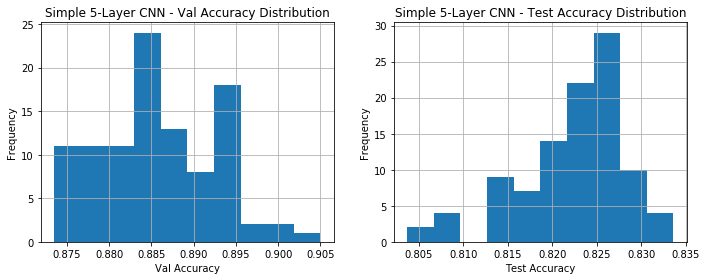

In [36]:
result=np.array(accuracies)

print ("Test Accuracy - mean:{:.4f}, std:{:.4f}".format(result[:,0].mean(), result[:,0].std() ))
print ("Validation Accuracy - mean:{:.4f}, std:{:.4f}".format(result[:,1].mean(), result[:,1].std() ))


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(result[:,1])
plt.xlabel('Val Accuracy')
plt.ylabel("Frequency")
plt.title("Simple 5-Layer CNN - Val Accuracy Distribution")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(result[:,0])
plt.xlabel('Test Accuracy')
plt.ylabel("Frequency")
plt.title("Simple 5-Layer CNN - Test Accuracy Distribution")
plt.grid(True)
plt.tight_layout()

plt.show()


## Ensemble Size

We put together randoms ensembles of 2,4,6,8 and 10 models. For each ensemble size, we look at the test accuracy distribution of these ensembles.

In [54]:
ensemble_sizes = [2,4,6,8,10,12]
max_count = 200  # Run random 

best_acc = 0.0
best_ensemble = []
ensemble_acc = np.zeros((max_count, len(ensemble_sizes)))
print (ensemble_acc.shape)

for size_idx, ensemble_size in enumerate(ensemble_sizes):
    
    for count in range(max_count):

        models = []

        ensemble = create_ensemble(files, ensemble_size)  # generate random ensemble of specified size
        models = load_ensemble_models(ensemble, generator_m2)   # load models with parameter files
        acc = calc_ensemble_accuracy(models)   # calculate ensemble accuracy
        
        if (acc > best_acc):   # Save the best ensemble accuracy and the ensemble model
            best_acc = acc
            best_ensemble = ensemble 
            
        ensemble_acc[count,size_idx] = acc  # Store in numpy array for analysis later
        
    print ("Ensemble size:{}  acc mean:{:.4f}, acc std:{:.4f}".format(ensemble_size, \
                                    ensemble_acc[:,size_idx].mean(), ensemble_acc[:,size_idx].std() ))



(200, 6)
Ensemble size:2  acc mean:0.8458, acc std:0.0036
Ensemble size:4  acc mean:0.8582, acc std:0.0024
Ensemble size:6  acc mean:0.8624, acc std:0.0022
Ensemble size:8  acc mean:0.8643, acc std:0.0020
Ensemble size:10  acc mean:0.8656, acc std:0.0021
Ensemble size:12  acc mean:0.8664, acc std:0.0017


## Best Ensemble

The best ensemble test accuracy achieved is 87.24% in after 1200 permutation runs. This is slightly lower than the 87.45% ensemble I got in DeepCNN-V2.

In [56]:
print (best_acc)
print (best_ensemble)
print (len(best_ensemble))


0.8724
['model2_reg=4.1178e-07lr=2.3090e-03ep=50bestacc.pt', 'model2_reg=8.1519e-07lr=2.8225e-03ep=50bestacc.pt', 'model2_reg=4.3000e-07lr=2.2251e-03ep=50bestacc.pt', 'model2_reg=6.1658e-08lr=2.0773e-03ep=50bestacc.pt', 'model2_reg=2.1807e-07lr=1.0457e-03ep=50bestacc.pt', 'model2_reg=6.8983e-07lr=1.2029e-03ep=50bestacc.pt', 'model2_reg=3.0475e-07lr=2.7241e-03ep=50bestacc.pt', 'model2_reg=6.6331e-07lr=2.0092e-03ep=50bestacc.pt', 'model2_reg=8.7445e-08lr=1.8169e-03ep=50bestacc.pt', 'model2_reg=5.1411e-07lr=1.3936e-03ep=50bestacc.pt']
10


Simple 5-Layer CNN: Ensemble=2
Test Accuracy - mean:0.8458, std:0.0036


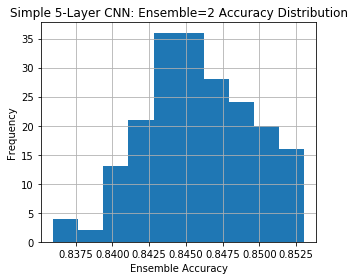

Simple 5-Layer CNN: Ensemble=4
Test Accuracy - mean:0.8582, std:0.0024


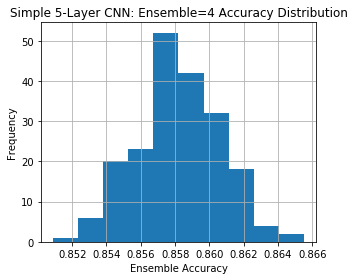

Simple 5-Layer CNN: Ensemble=6
Test Accuracy - mean:0.8624, std:0.0022


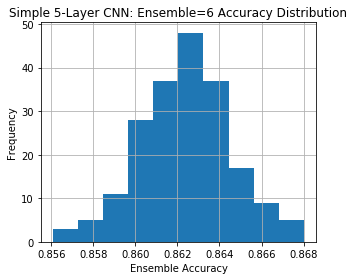

Simple 5-Layer CNN: Ensemble=8
Test Accuracy - mean:0.8643, std:0.0020


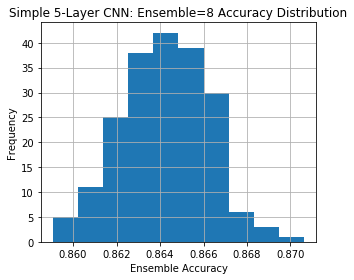

Simple 5-Layer CNN: Ensemble=10
Test Accuracy - mean:0.8656, std:0.0021


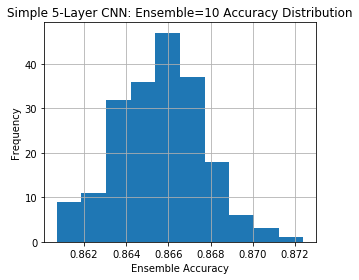

Simple 5-Layer CNN: Ensemble=12
Test Accuracy - mean:0.8664, std:0.0017


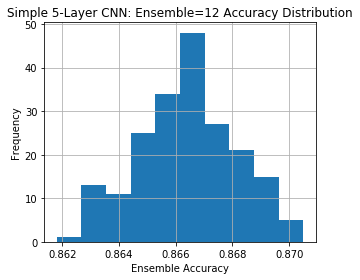

In [61]:
ensemble_sizes = [2,4,6,8,10,12]

for size_idx, ensemble_size in enumerate(ensemble_sizes):
    print ("Simple 5-Layer CNN: Ensemble="+str(ensemble_size))
    print ("Test Accuracy - mean:{:.4f}, std:{:.4f}".format(ensemble_acc[:,size_idx].mean(), \
                                                            ensemble_acc[:,size_idx].std() ))
    plt.figure(figsize=(5, 4))
    plt.hist(ensemble_acc[:,size_idx])
    plt.xlabel('Ensemble Accuracy')
    plt.ylabel("Frequency")
    plt.title("Simple 5-Layer CNN: Ensemble="+str(ensemble_size) +" Accuracy Distribution")
    plt.grid(True)
    plt.tight_layout()

    plt.show()


## Model Filtering

We will repeat the exercise in the previous section with a filtered model parameter list. Instead of all 100 permutations, we will use 50 permutations with the highest validation accuracies.

In [86]:
files = []

for _,_,filepath in sorted_list:   # model parameters files in descending order of validation accuracy
    files.append(filepath)
    
num_files = 50  # We create ensembles with top 50 models with highest validation accuracies

ensemble_sizes = [2,4,6,8,10,12]
max_count = 200  # Run random 

best_acc = 0.0
best_ensemble = []
ensemble_acc = np.zeros((max_count, len(ensemble_sizes)))
print (ensemble_acc.shape)

for size_idx, ensemble_size in enumerate(ensemble_sizes):
    
    for count in range(max_count):

        models = []

        ensemble = create_ensemble(files[:-(num_files+1)], ensemble_size)  # generate random ensemble of specified size
        models = load_ensemble_models(ensemble, generator_m2)   # load models with parameter files
        acc = calc_ensemble_accuracy(models)   # calculate ensemble accuracy
        
        if (acc > best_acc):   # Save the best ensemble accuracy and the ensemble model
            best_acc = acc
            best_ensemble = ensemble 
            
        ensemble_acc[count,size_idx] = acc  # Store in numpy array for analysis later
        
    print ("Ensemble size:{}  acc mean:{:.4f}, acc std:{:.4f}".format(ensemble_size, \
                                    ensemble_acc[:,size_idx].mean(), ensemble_acc[:,size_idx].std() ))



(200, 6)
Ensemble size:2  acc mean:0.8475, acc std:0.0033
Ensemble size:4  acc mean:0.8595, acc std:0.0026
Ensemble size:6  acc mean:0.8633, acc std:0.0024
Ensemble size:8  acc mean:0.8654, acc std:0.0020
Ensemble size:10  acc mean:0.8663, acc std:0.0019
Ensemble size:12  acc mean:0.8673, acc std:0.0018


In [87]:
print (best_acc)
print (best_ensemble)
print (len(best_ensemble))

0.8724
['./m2-50ep-results/model2_reg=9.2765e-07lr=2.2260e-03ep=50bestacc.pt', './m2-50ep-results/model2_reg=6.6331e-07lr=2.0092e-03ep=50bestacc.pt', './m2-50ep-results/model2_reg=9.0743e-07lr=1.1935e-03ep=50bestacc.pt', './m2-50ep-results/model2_reg=2.9615e-07lr=1.8221e-03ep=50bestacc.pt', './m2-50ep-results/model2_reg=5.1383e-08lr=2.0657e-03ep=50bestacc.pt', './m2-50ep-results/model2_reg=9.3219e-07lr=1.9515e-03ep=50bestacc.pt', './m2-50ep-results/model2_reg=4.1310e-07lr=1.7359e-03ep=50bestacc.pt', './m2-50ep-results/model2_reg=8.0645e-07lr=2.8098e-03ep=50bestacc.pt', './m2-50ep-results/model2_reg=2.1457e-07lr=1.1381e-03ep=50bestacc.pt', './m2-50ep-results/model2_reg=1.4985e-07lr=2.0060e-03ep=50bestacc.pt', './m2-50ep-results/model2_reg=1.0000e-07lr=1.4898e-03ep=50bestacc.pt', './m2-50ep-results/model2_reg=2.1750e-07lr=2.0037e-03ep=50bestacc.pt']
12


In [ ]:
ensemble_sizes = [2,4,6,8,10,12]

for size_idx, ensemble_size in enumerate(ensemble_sizes):
    print ("Simple 5-Layer CNN: Ensemble="+str(ensemble_size))
    print ("Test Accuracy - mean:{:.4f}, std:{:.4f}".format(ensemble_acc[:,size_idx].mean(), \
                                                            ensemble_acc[:,size_idx].std() ))
    plt.figure(figsize=(5, 4))
    plt.hist(ensemble_acc[:,size_idx])
    plt.xlabel('Ensemble Accuracy')
    plt.ylabel("Frequency")
    plt.title("Simple 5-Layer CNN: Ensemble="+str(ensemble_size) +" Accuracy Distribution")
    plt.grid(True)
    plt.tight_layout()

    plt.show()